In [1]:
from label_ranking import *
from dataloader import *
from evaluator import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from rdkit import Chem
from scipy.stats.mstats import rankdata

np.random.seed(42)

In [2]:
def rr(test_yield, test_rank, pred_rank):
    predicted_highest_yield_inds = np.argpartition(
        pred_rank, 1, axis=1
    )[:, : 1]
    best_retrieved_yield = [
        np.max(test_yield[i, row])
        for i, row in enumerate(predicted_highest_yield_inds)
    ]
    actual_inds_with_that_yield = [
        np.where(test_yield[i, :] == best_y)[0]
        for i, best_y in enumerate(best_retrieved_yield)
    ]
    rr = [
        1 / np.min(test_rank[a, x])
        for a, x in enumerate(actual_inds_with_that_yield)
    ]
    return rr

def kt(test_rank, pred_rank):
    kt = [
        kendalltau(test_rank[i, :], pred_rank[i, :]).statistic
        for i in range(pred_rank.shape[0])
    ]
    return kt

def update_perf_dict(dict_to_update, strategy, rr, kt, n_total_rxn):
    dict_to_update["Strategy"].append(strategy)
    dict_to_update["Reciprocal Rank"].append(rr)
    dict_to_update["Kendall Tau"].append(kt)
    dict_to_update["Substrates Sampled"].append(n_total_rxn)

# NatureHTE amine dataset

In [3]:
amine_dataset = NatureDataset(False, "amine", 1)
X_fp = amine_dataset.X_fp
y_ranking = amine_dataset.y_ranking
y_yield = amine_dataset.y_yield

In [4]:
# First randomly select four substrates with four top classes
N_TEST_CASES = 4
test_inds = []
for i in range(4):
    test_inds.extend(list(np.random.choice(np.where(y_ranking[:, i] == 1)[0], N_TEST_CASES, replace=False)))
train_inds = [x for x in range(X_fp.shape[0]) if x not in test_inds]

X_test = X_fp[test_inds]
y_test = y_ranking[test_inds]
y_test_yield = y_yield[test_inds]
# Randomly selecting six initial substrates with all four reaction conditions
N_INITIAL_SUBS = 6

In [9]:
### Full data
full_rpc = RPC()
full_rpc.fit(X_fp[train_inds], y_ranking[train_inds])
full_pred_rank = full_rpc.predict(X_test)
print("FULL RR", np.mean(np.array(rr(y_test_yield, y_test, full_pred_rank))))

0.5520833333333333
Num remaining inds 2

FULL RR 0.49999999999999994


In [13]:
# Strategy 3
N_CONDS_TO_SAMPLE = 2
N_SUBS_TO_SAMPLE = 2

strategy3_perf_dict = {
    "Strategy":[],
    "Reciprocal Rank":[],
    "Kendall Tau":[],
    "Substrates Sampled":[]
}

for n_iter in range(25) :
    initial_inds = np.random.choice(train_inds, N_INITIAL_SUBS, replace=False)
    rem_inds = [x for x in train_inds if x not in initial_inds] # keeps track of SUBSTRATE INDICES

    X_sampled = X_fp[initial_inds]
    y_sampled = y_ranking[initial_inds]

    
    update_perf_dict(
        strategy3_perf_dict, 3, 
        np.mean(np.array(rr(y_test_yield, y_test, y_pred_init))), 
        np.mean(np.array(kt(y_test, y_pred_init))),
        6
    )
    n_sampled = 6

    ### Initial
    initial_rpc = RPC()
    initial_rpc.fit(X_sampled, y_sampled)
    y_pred_init = initial_rpc.predict(X_test)
    print(np.mean(np.array(rr(y_test_yield, y_test, y_pred_init))))

    rem_proba_array = initial_rpc.predict_proba(X_fp[rem_inds])
    print("Num remaining inds", len(rem_inds))
    print()
    
    while len(rem_inds) > 2 :
        top_two_proba = np.partition(np.sum(rem_proba_array, axis=1), 2, axis=1)[:, N_CONDS_TO_SAMPLE:]
        top_two_conds = np.argpartition(np.sum(rem_proba_array, axis=1), 2, axis=1)[:, N_CONDS_TO_SAMPLE:]
        next_subs_inds = np.argpartition(np.abs(top_two_proba[:, 0] - top_two_proba[:, 1]), N_SUBS_TO_SAMPLE)[:N_SUBS_TO_SAMPLE]
        next_cond_inds = top_two_conds[next_subs_inds, :]

        X_sampled = np.vstack((
            X_sampled, 
            X_fp[[rem_inds[x] for x in next_subs_inds]]
        ))
        acquired_y_ranking = deepcopy(y_ranking[[rem_inds[x] for x in next_subs_inds]]).astype(float)
        for i, row in enumerate(next_cond_inds) :
            inds_to_cover = [x for x in range(y_ranking.shape[1]) if x not in row]
            acquired_y_ranking[i, inds_to_cover] = np.nan
            acquired_y_ranking[i] = rankdata(acquired_y_ranking[i])
            acquired_y_ranking[i, inds_to_cover] = np.nan
        print(acquired_y_ranking)
        print()

        y_sampled = np.vstack((
            y_sampled,
            acquired_y_ranking
        ))

        rpc=RPC()
        rpc.fit(X_sampled, y_sampled)
        y_pred_init = rpc.predict(X_test)
        n_sampled += 2
        update_perf_dict(
            strategy3_perf_dict, 3, 
            np.mean(np.array(rr(y_test_yield, y_test, y_pred_init))), 
            np.mean(np.array(kt(y_test, y_pred_init))),
            n_sampled
        )
        rem_inds = [x for i, x in enumerate(rem_inds) if i not in next_subs_inds]
        print("Num remaining inds", len(rem_inds))
        rem_proba_array = rpc.predict_proba(X_fp[rem_inds])

0.5416666666666666
Num remaining inds 32

[[ 1. nan nan  2.]
 [nan nan  2.  1.]]

Num remaining inds 30
[[nan nan  1.  2.]
 [nan nan  2.  1.]]

Num remaining inds 28
[[nan nan  2.  1.]
 [nan nan  1.  2.]]

Num remaining inds 26
[[nan nan 1.  2. ]
 [nan nan 1.5 1.5]]

Num remaining inds 24
[[nan nan 2.  1. ]
 [nan nan 1.5 1.5]]

Num remaining inds 22
[[nan nan 2.  1. ]
 [1.5 nan nan 1.5]]

Num remaining inds 20
[[nan nan  1.  2.]
 [ 1. nan nan  2.]]

Num remaining inds 18
[[nan nan  2.  1.]
 [nan nan  2.  1.]]

Num remaining inds 16
[[nan nan  1.  2.]
 [nan nan  2.  1.]]

Num remaining inds 14
[[nan nan  2.  1.]
 [nan nan  2.  1.]]

Num remaining inds 12
[[nan nan  1.  2.]
 [nan nan  1.  2.]]

Num remaining inds 10
[[nan nan  1.  2.]
 [nan nan  1.  2.]]

Num remaining inds 8
[[nan nan 2.  1. ]
 [nan nan 1.5 1.5]]

Num remaining inds 6
[[nan nan  1.  2.]
 [nan nan  2.  1.]]

Num remaining inds 4
[[nan nan  1.  2.]
 [nan nan  2.  1.]]

Num remaining inds 2
0.640625
Num remaining inds 32



In [14]:
pd.DataFrame(strategy3_perf_dict)

,Strategy,Reciprocal Rank,Kendall Tau,Substrates Sampled
0,3,0.567708,0.065821,6
1,3,0.541667,0.050550,8
2,3,0.541667,0.008883,10
3,3,0.541667,0.008883,12
4,3,0.541667,0.017513,14
...,...,...,...,...
395,3,0.494792,-0.120094,28
396,3,0.453125,-0.099260,30
397,3,0.453125,-0.099260,32
398,3,0.453125,-0.099260,34


<Axes: xlabel='Substrates Sampled', ylabel='Reciprocal Rank'>

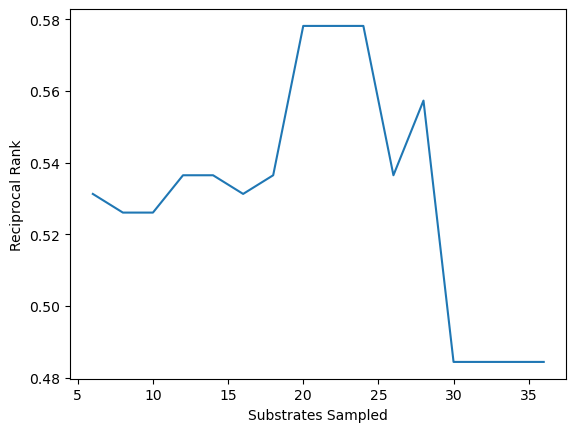

In [20]:
sns.lineplot(pd.DataFrame(strategy3_perf_dict).iloc[48:64, :], y="Reciprocal Rank", x="Substrates Sampled", markers=True)

<Axes: xlabel='Substrates Sampled', ylabel='Kendall Tau'>

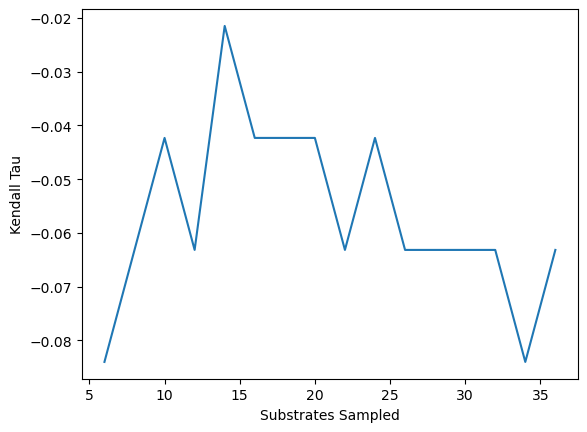

In [9]:
sns.lineplot(pd.DataFrame(strategy3_perf_dict), y="Kendall Tau", x="Substrates Sampled")

[0,
 1,
 4,
 5,
 6,
 7,
 10,
 11,
 15,
 16,
 18,
 19,
 21,
 24,
 25,
 26,
 28,
 33,
 34,
 35,
 37,
 38,
 40,
 41,
 42,
 43,
 46,
 50,
 51,
 53]

In [24]:
np.sum(rem_proba_array, axis=1)[[17,28]]

array([[1.48529975, 2.07994153, 1.98999054, 0.44476818],
       [1.52456655, 2.13495273, 2.0289525 , 0.31152821]])

In [10]:
rem_proba_array[np.argmin(np.std(np.sum(rem_proba_array, axis=2), axis=1)), :, :]

array([[0.        , 0.5       , 0.85670842, 0.4861562 ],
       [0.5       , 0.        , 0.45972784, 0.41763473],
       [0.14329158, 0.54027216, 0.        , 0.50595455],
       [0.5138438 , 0.58236527, 0.49404545, 0.        ]])

In [11]:
np.sum(rem_proba_array[np.argmin(np.std(np.sum(rem_proba_array, axis=2), axis=1)), :, :], axis=1)

array([1.84286462, 1.37736257, 1.18951829, 1.59025451])

In [13]:
initial_rpc.predict(X_fp[rem_inds[np.argmin(np.std(np.sum(rem_proba_array, axis=2), axis=1))]].reshape(1,-1))

array([[1, 3, 4, 2]])

In [14]:
y_ranking[rem_inds[np.argmin(np.std(np.sum(rem_proba_array, axis=2), axis=1))]]

array([1, 4, 4, 4])

In [15]:
# Strategy 1 : Get pair of reactions where the average of pred proba across all candidates are closest to 0.5
# --> then select 2 substrates with lowest tanimoto similarity to those sampled?

# Strategy 2 : Select two substrates with lowest std across the reaction conditions
# --> then select pair with probability value closest to 0.5

# Strategy 3 : Select pairs of conditions where the difference between the top 2 are the smallest

# Baselines
# AL ----------------------
# 1) random selection
# 2) selecting substrates but sampling all conditions
# Static ------------------
# 3) With full data RFR and RPC